In [1]:
from imageio import imread




from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.utils import resample
from sklearn.model_selection import KFold, cross_val_score

In [2]:
# Defining the Mean square error, from lecture notes
def MSE(y,ytilde):
    n = len(y)
    return 1/n * np.sum(np.abs(y-ytilde)**2)




# Defining the R2 function, from lecture notes
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)



def printQ(xdata,xmodel):
    print("--------------------------------------------------------")
    print(f"MSE = |{MSE(xdata,xmodel)}|, R2 = |{r2_score(xdata,xmodel)}|")
    print("--------------------------------------------------------\n")
    


# Creating the design matrix, from lecture notes
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X


# making the OCS regression
def OLSmethod(X,z):
    return np.linalg.pinv(X.T @ X) @ X.T @ z

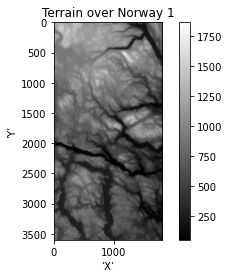

(3601, 1801)
(2400, 1200)
(1600, 800)
(1066, 533)
(710, 355)
(473, 236)
(315, 157)
(210, 104)


In [3]:
# Load the terrain
data = imread("SRTM_data_Norway_1.tif")
# Show the terrain
#print(type(data))
#data = np.array(terrain1)
#print(data.shape)
#print(data)
plt.figure()
plt.title("Terrain over Norway 1")
plt.imshow(data, cmap="gray")
plt.xlabel("’X’")
plt.colorbar()
plt.ylabel("’Y’")
plt.show()
for i in range(8):
        print(data.shape)
        data = np.delete(data, slice(None, None, 3), axis=0)
        data = np.delete(data, slice(None, None, 3), axis=1)
        



Text(0, 0.5, 'Value')

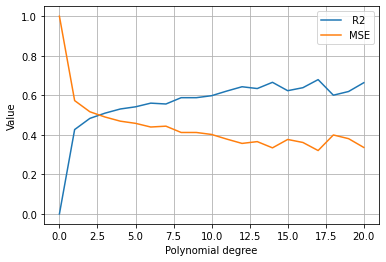

In [22]:



n,m = data.shape
#print(n,m)



# Make data.
x = np.linspace(0, 1801, m)
y = np.linspace(0, 3601, n)



npoly1 = np.arange(0,21)

x,y = np.meshgrid(x,y)


z = data
R2test = []
MSEtest = []

for npoly in npoly1:
    #print(f"---{npoly}---")
    X = create_X(x,y,npoly)


    X_train, X_test, z_train, z_test = train_test_split(X,z.reshape(-1,1), test_size = 0.2)

    #Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    z_train_scaled = scaler.fit_transform(z_train)
    z_test_scaled = scaler.fit_transform(z_test)

    X_scaled = scaler.fit_transform(X)
    z_scaled = scaler.fit_transform(z)


    beta = OLSmethod(X_train_scaled,z_train_scaled)

    ztilde = X_train_scaled @ beta
    #printQ(z_train_scaled,ztilde)
    
    zpred = X_test_scaled @ beta
    #printQ(z_test_scaled,zpred)
    MSEtest.append(MSE(z_test_scaled,zpred))
    R2test.append(R2(z_test_scaled,zpred))



    
plt.plot(npoly1,R2test, label =" R2")
plt.plot(npoly1,MSEtest,label = "MSE")
plt.legend()
plt.grid()
plt.xlabel("Polynomial degree")
plt.ylabel("Value")

In [ ]:
plt.imshow(z_scaled, cmap="gray")
plt.colorbar()
plt.show()


plt.imshow((X_scaled@beta).reshape(n,m), cmap="gray")
plt.colorbar()
plt.show()